## Question 4: Implementing the feedforward model

### a)
Instantiate a pre-trained version of the VGG_11_bn model with ImageNet pre-trained weights. Then, we add two fully connected layers on top, with BatchNorm and ReLU layers between them to build the CIFAR-10 10-class classifier.

We train only the newly added layers while disabling gradients for the rest of the network.

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


In [ ]:
#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
layer_config= [512, 256]
num_classes = 10
num_epochs = 30
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.99
reg=0#0.001
num_training= 49000
num_validation =1000
fine_tune = True
pretrained = True

In [ ]:
#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
data_aug_transforms = [transforms.RandomHorizontalFlip(p=0.5)]#, transforms.RandomGrayscale(p=0.05)]
###############################################################################
# TODO: Add to data_aug_transforms the best performing data augmentation      #
# strategy and hyper-parameters as found out in Q3.a                          #
###############################################################################

norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     ]) #Need to preserve the normalization values of the pre-trained model
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets/


In [ ]:
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

In [ ]:
#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
## Vgg model
class VggModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(VggModel, self).__init__()
        #################################################################################
        # TODO: Build the classification network described in Q4 using the              #
        # models.vgg11_bn network from torchvision model zoo as the feature extraction  #
        # layers and two linear layers on top for classification. You can load the      #
        # pretrained ImageNet weights based on the pretrained flag. You can enable and  #
        # disable training the feature extraction layers based on the fine_tune flag.   #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        ## Init Model
        model_pretrained = models.vgg11_bn(pretrained = True)
  
        self.vgg = model_pretrained.features
        self.new_layers = nn.Sequential(nn.Flatten(), nn.Linear(512, 256, bias = True),
                                        nn.BatchNorm1d(256),
                                        nn.ReLU(inplace = True),
                                        nn.Linear(256, 10, bias = True))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = self.vgg(x)
        out = self.new_layers(x)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [ ]:
# Initialize the model for this run
model = VggModel(num_classes, fine_tune, pretrained)

if (pretrained==False):
    model.apply(weights_init)

# Print the model we just instantiated
# print(model.pretrained)
# print(model.new_layers)

#################################################################################
# TODO: Only select the required parameters to pass to the optimizer. No need to#
# update parameters which should be held fixed (conv layers).                   #
#################################################################################
print("Params to learn:")
if fine_tune:
    params_to_update = []
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # Disabling gradients
    for param in model.vgg.parameters():
        param.requires_grad = False
    
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
else:
    params_to_update = model.parameters()
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Params to learn:
	 new_layers.1.weight
	 new_layers.1.bias
	 new_layers.2.weight
	 new_layers.2.bias
	 new_layers.4.weight
	 new_layers.4.bias


In [ ]:
## Check
model.to(device)

VggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
best_model = type(model)(num_classes, fine_tune, pretrained) # get a new instance
for epoch in range(num_epochs):

    model.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    epoch_loss_train = loss_iter/(len(train_loader)*batch_size)
    loss_train.append(epoch_loss_train)


    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
            
        epoch_loss_val = loss_iter/(len(train_loader)*batch_size)
        loss_val.append(epoch_loss_val)

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        
        print('Validataion accuracy is: {} %'.format(accuracy))
        #################################################################################
        # TODO: Q2.b Use the early stopping mechanism from previous questions to save   #
        # the model with the best validation accuracy so-far (use best_model).          #
        #################################################################################

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # early stopping
        # early_stopping(epoch_loss_train, epoch_loss_val)
        # if early_stopping.early_stop:
        #     print("We are at epoch:", epoch)
        #     break


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()




#################################################################################
# TODO: Use the early stopping mechanism from previous question to load the     #
# weights from the best model so far and perform testing with this model.       #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))



# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/30], Step [100/245], Loss: 1.1102
Epoch [1/30], Step [200/245], Loss: 1.2154
Validataion accuracy is: 62.4 %
Epoch [2/30], Step [100/245], Loss: 1.0311
Epoch [2/30], Step [200/245], Loss: 1.0169
Validataion accuracy is: 61.2 %
Epoch [3/30], Step [100/245], Loss: 0.8961
Epoch [3/30], Step [200/245], Loss: 0.8990
Validataion accuracy is: 62.0 %
Epoch [4/30], Step [100/245], Loss: 1.1081
Epoch [4/30], Step [200/245], Loss: 1.0366
Validataion accuracy is: 63.6 %
Epoch [5/30], Step [100/245], Loss: 0.7136
Epoch [5/30], Step [200/245], Loss: 1.0585
Validataion accuracy is: 64.1 %
Epoch [6/30], Step [100/245], Loss: 0.8877
Epoch [6/30], Step [200/245], Loss: 0.9009
Validataion accuracy is: 64.7 %
Epoch [7/30], Step [100/245], Loss: 0.8118
Epoch [7/30], Step [200/245], Loss: 0.9193
Validataion accuracy is: 63.3 %
Epoch [8/30], Step [100/245], Loss: 0.8377
Epoch [8/30], Step [200/245], Loss: 0.8410
Validataion accuracy is: 63.9 %
Epoch [9/30], Step [100/245], Loss: 0.8117
Epoch [9/30],

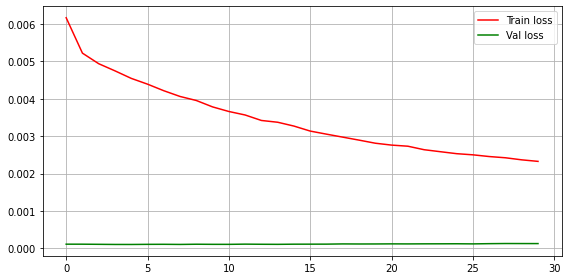

--------------------------------------------------------------------------


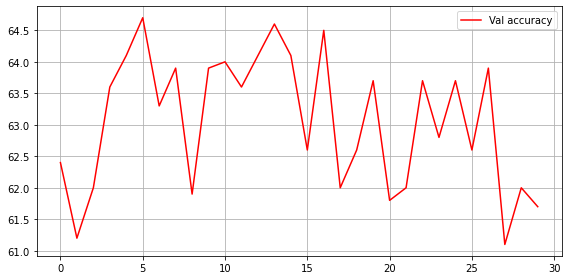

In [ ]:
## Plot
plt.rcParams["figure.figsize"] = (8,4)
plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

plt.rcParams["figure.figsize"] = (8,4)
plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see, training only the newly added layers and disabling gradients for the rest of the network, we don't obtain a high performance. Maybe the features extraction process is useful for the classification.

The plot confirms that the validation accuracy is in the range **61% - 65%**.

### b)
To improve the performance we can fine-tune the whole network on the CIFAR-10 dataset, starting from the ImageNet initialization. To do this, enable gradient computation to the rest of the network, and update all the model
parameters.

In [ ]:
## Initialize the model for this run
model_grad_on = VggModel(num_classes, fine_tune, pretrained)

if (pretrained==False):
    model_grad_on.apply(weights_init)


print("Params to learn:")
if fine_tune:
    params_to_update = []
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    for name,param in model_grad_on.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
else:
    params_to_update = model_grad_on.parameters()
    for name,param in model_grad_on.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

Params to learn:
	 vgg.0.weight
	 vgg.0.bias
	 vgg.1.weight
	 vgg.1.bias
	 vgg.4.weight
	 vgg.4.bias
	 vgg.5.weight
	 vgg.5.bias
	 vgg.8.weight
	 vgg.8.bias
	 vgg.9.weight
	 vgg.9.bias
	 vgg.11.weight
	 vgg.11.bias
	 vgg.12.weight
	 vgg.12.bias
	 vgg.15.weight
	 vgg.15.bias
	 vgg.16.weight
	 vgg.16.bias
	 vgg.18.weight
	 vgg.18.bias
	 vgg.19.weight
	 vgg.19.bias
	 vgg.22.weight
	 vgg.22.bias
	 vgg.23.weight
	 vgg.23.bias
	 vgg.25.weight
	 vgg.25.bias
	 vgg.26.weight
	 vgg.26.bias
	 new_layers.1.weight
	 new_layers.1.bias
	 new_layers.2.weight
	 new_layers.2.bias
	 new_layers.4.weight
	 new_layers.4.bias


In [ ]:
## Check
model_grad_on.to(device)

VggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
best_model = type(model_grad_on)(num_classes, fine_tune, pretrained) # get a new instance
for epoch in range(num_epochs):

    model_grad_on.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_grad_on(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    epoch_loss_train = loss_iter/(len(train_loader)*batch_size)
    loss_train.append(epoch_loss_train)


    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    
    model_grad_on.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_grad_on(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
            
        epoch_loss_val = loss_iter/(len(train_loader)*batch_size)
        loss_val.append(epoch_loss_val)

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        
        print('Validataion accuracy is: {} %'.format(accuracy))

   

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model_grad_on.eval()


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_grad_on(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Epoch [1/30], Step [100/245], Loss: 0.7034
Epoch [1/30], Step [200/245], Loss: 0.4856
Validataion accuracy is: 80.1 %
Epoch [2/30], Step [100/245], Loss: 0.4337
Epoch [2/30], Step [200/245], Loss: 0.3527
Validataion accuracy is: 84.1 %
Epoch [3/30], Step [100/245], Loss: 0.3030
Epoch [3/30], Step [200/245], Loss: 0.2511
Validataion accuracy is: 88.6 %
Epoch [4/30], Step [100/245], Loss: 0.2114
Epoch [4/30], Step [200/245], Loss: 0.2472
Validataion accuracy is: 85.7 %
Epoch [5/30], Step [100/245], Loss: 0.2137
Epoch [5/30], Step [200/245], Loss: 0.1914
Validataion accuracy is: 87.0 %
Epoch [6/30], Step [100/245], Loss: 0.1833
Epoch [6/30], Step [200/245], Loss: 0.1596
Validataion accuracy is: 87.7 %
Epoch [7/30], Step [100/245], Loss: 0.0779
Epoch [7/30], Step [200/245], Loss: 0.0997
Validataion accuracy is: 86.4 %
Epoch [8/30], Step [100/245], Loss: 0.0761
Epoch [8/30], Step [200/245], Loss: 0.0524
Validataion accuracy is: 88.0 %
Epoch [9/30], Step [100/245], Loss: 0.1218
Epoch [9/30],

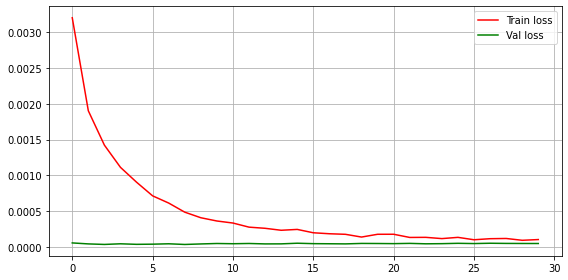

--------------------------------------------------------------------------


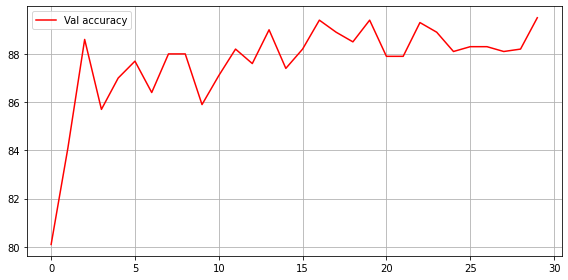

In [ ]:
## Plot
plt.rcParams["figure.figsize"] = (8,4)
plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

plt.rcParams["figure.figsize"] = (8,4)
plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We confirm what was said previously, in fact enabling the gradients for the rest of the network and updating all the model parameters, the performance is much better.

Additionally train a baseline model where the same entire network is trained from scratch, without loading the ImageNet weights.

In [ ]:
## Init
# model_no_pretrained = models.vgg11_bn(pretrained = False, num_classes = 10)
model_no_pretrained = VggModel(num_classes, fine_tune, pretrained = False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
## Apply weights
if (pretrained==False):
    model_no_pretrained.apply(weights_init)

print("Params to learn:")
if fine_tune:
    params_to_update = []
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # Disabling gradients
    # for param in model.vgg.parameters():
    #     param.requires_grad = False
    
    for name,param in model_no_pretrained.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
else:
    params_to_update = model_no_pretrained.parameters()
    for name,param in model_no_pretrained.named_parameters():
        if param.requires_grad == True:
            print("\t", name)

Params to learn:
	 vgg.0.weight
	 vgg.0.bias
	 vgg.1.weight
	 vgg.1.bias
	 vgg.4.weight
	 vgg.4.bias
	 vgg.5.weight
	 vgg.5.bias
	 vgg.8.weight
	 vgg.8.bias
	 vgg.9.weight
	 vgg.9.bias
	 vgg.11.weight
	 vgg.11.bias
	 vgg.12.weight
	 vgg.12.bias
	 vgg.15.weight
	 vgg.15.bias
	 vgg.16.weight
	 vgg.16.bias
	 vgg.18.weight
	 vgg.18.bias
	 vgg.19.weight
	 vgg.19.bias
	 vgg.22.weight
	 vgg.22.bias
	 vgg.23.weight
	 vgg.23.bias
	 vgg.25.weight
	 vgg.25.bias
	 vgg.26.weight
	 vgg.26.bias
	 new_layers.1.weight
	 new_layers.1.bias
	 new_layers.2.weight
	 new_layers.2.bias
	 new_layers.4.weight
	 new_layers.4.bias


In [ ]:
## Check
model_no_pretrained.to(device)

VggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
# best_model = type(model_no_pretrained)(num_classes, fine_tune, pretrained) # get a new instance
for epoch in range(num_epochs):

    model_no_pretrained.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_no_pretrained(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    epoch_loss_train = loss_iter/(len(train_loader)*batch_size)
    loss_train.append(epoch_loss_train)


    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    
    model_no_pretrained.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_no_pretrained(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
            
        epoch_loss_val = loss_iter/(len(train_loader)*batch_size)
        loss_val.append(epoch_loss_val)

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        
        print('Validataion accuracy is: {} %'.format(accuracy))


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model_no_pretrained.eval()


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_no_pretrained(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Epoch [1/30], Step [100/245], Loss: 0.5310
Epoch [1/30], Step [200/245], Loss: 0.4816
Validataion accuracy is: 73.5 %
Epoch [2/30], Step [100/245], Loss: 0.2867
Epoch [2/30], Step [200/245], Loss: 0.2484
Validataion accuracy is: 85.3 %
Epoch [3/30], Step [100/245], Loss: 0.3127
Epoch [3/30], Step [200/245], Loss: 0.3433
Validataion accuracy is: 87.0 %
Epoch [4/30], Step [100/245], Loss: 0.2790
Epoch [4/30], Step [200/245], Loss: 0.2565
Validataion accuracy is: 84.4 %
Epoch [5/30], Step [100/245], Loss: 0.1634
Epoch [5/30], Step [200/245], Loss: 0.1821
Validataion accuracy is: 89.1 %
Epoch [6/30], Step [100/245], Loss: 0.1505
Epoch [6/30], Step [200/245], Loss: 0.1383
Validataion accuracy is: 85.3 %
Epoch [7/30], Step [100/245], Loss: 0.1395
Epoch [7/30], Step [200/245], Loss: 0.0694
Validataion accuracy is: 88.4 %
Epoch [8/30], Step [100/245], Loss: 0.0760
Epoch [8/30], Step [200/245], Loss: 0.0482
Validataion accuracy is: 87.1 %
Epoch [9/30], Step [100/245], Loss: 0.0724
Epoch [9/30],

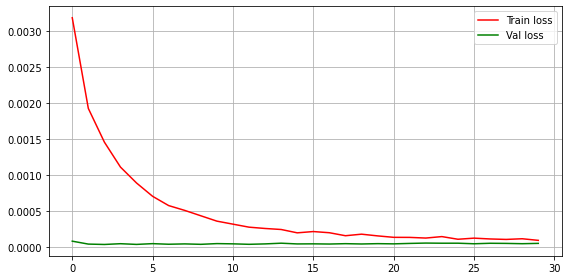

--------------------------------------------------------------------------


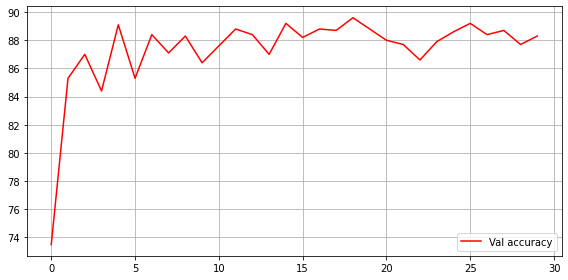

In [ ]:
## Plot
plt.rcParams["figure.figsize"] = (8,4)
plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

plt.rcParams["figure.figsize"] = (8,4)
plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In this step, the same entire network is trained from scratch without loading the ImageNet weights. It's clear that in the end we obtain more or less the same performance in terms of accuracy but we note that using the pretrained model, we reach this performance with few epochs, while training from scratch we reach it after a while because the network needs to learn the parameters.